#### Getting Started with FashionMNIST

This notebook shows how to load the FashionMNIST dataset in PyTorch and illustrates what kind of samples it contains.

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
#from utils.dice_score import multiclass_dice_coeff, dice_coeff

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformationen definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisiert Daten auf [-1, 1]
])

# Erstellen Sie eine Instanz des Trainingssplits des FashionMNIST-Datasets
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Jetzt erstellen Sie eine Instanz des Testsplits
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Für unsere Zwecke können wir die 60k Training- und 10k Testbeispiele kombinieren
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset_train, dataset_valid])

# Einige Informationen zum Datensatz anzeigen
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=1024,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(dataset_valid, batch_size=1024,
                                       shuffle=True, num_workers=2)



print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


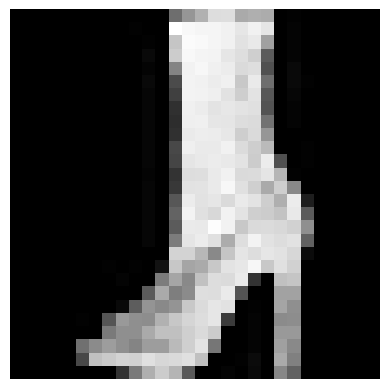

The image shows an instance of Ankle boot.


In [3]:
# we can also visualize and describe a sample
fig, ax = plt.subplots()
ax.imshow(img_tensor.cpu().squeeze(), cmap='Greys_r')
plt.axis('off')
plt.show()
print('The image shows an instance of ' + dataset_train.classes[class_label.item()] + '.')

In [4]:
min_value = torch.min(img_tensor)
max_value = torch.max(img_tensor)

print(f"Minimaler Wert: {min_value.item()}")
print(f"Maximaler Wert: {max_value.item()}")



Minimaler Wert: -1.0
Maximaler Wert: 1.0


In [5]:
# handvoll resisdual basic blocks -> flatten -> handvoll fully conntected layers
# resnet basic block : conv3x3 + norm_layer + non_lin + conv3x3 + normlayer
# identity: conv1x1 + norm layer
# output: non_lin(identity_layers(x) + [conv3x3 + norm_layer + non_lin + conv3x3 + normlayer](x))

In [6]:
def create_linear_schedule(steps, start, end):
    step_size = (end - start) / (steps - 1)  
    linear_schedule = []
    for i in range(steps):
        linear_schedule.append(start + i * step_size)
    return linear_schedule



In [7]:
def normalize_image(image):
    min_value = torch.min(image)
    max_value = torch.max(image)
    
    normalized_image = 2 * ((image - min_value) / (max_value - min_value)) - 1
    return normalized_image

In [8]:
# Function to add Gaussian noise to an image tensor
def add_gaussian_noise(image, mean=0., std=1.):
    eps = torch.empty_like(image).normal_(mean=0,std=1)
    noise = eps * std + mean
    # beta*eps + sqrt(1-beta)*image+std # (1-beta).sqrt()*image + beta*eps
    # Clip the values to be between 0 and 1
    # noisy_image = normalize_image(noisy_image)
    return noise, eps

In [9]:
def one_forward_step(curr_image, beta):
    std = np.sqrt(beta) #* np.random.normal()#* np.identity(like=curr_image) Nicht notwendig da äquivalent zu Skalar von Rechts
    mean = np.sqrt(1-beta) * curr_image #+ std
    image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return image

In [10]:
def mache_noise(image, anzahl_bilder):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    # Display the original image
    plt.imshow(image.cpu().squeeze())
    plt.title("Original Image")
    plt.show()
    
    verrauschte_bilder = []
    schedule = create_linear_schedule(anzahl_bilder, 0.0001, 0.02)
    print(schedule)
    noisy_image_tensor = image
    for i in range(len(schedule)):
        noisy_image_tensor = one_forward_step(noisy_image_tensor, schedule[i])
        
        # Convert the noisy image tensor back to a PIL image
        noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
        
        verrauschte_bilder.append(noisy_image)
        
        # Optional: Display each noisy image if desired
        plt.imshow(noisy_image, cmap='Greys_r')
        plt.title(f"Noisy Image {i+1}: {noisy_image_tensor.mean()}, {noisy_image_tensor.std()}")
        plt.show()
    

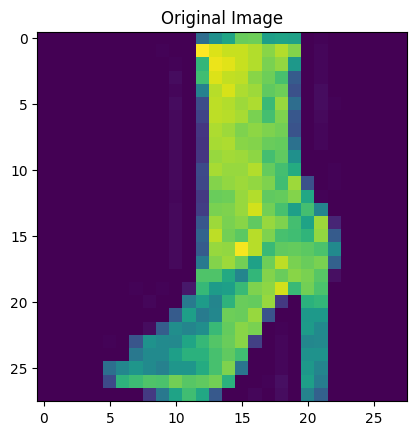

[0.0001, 0.0050750000000000005, 0.01005, 0.015025, 0.02]


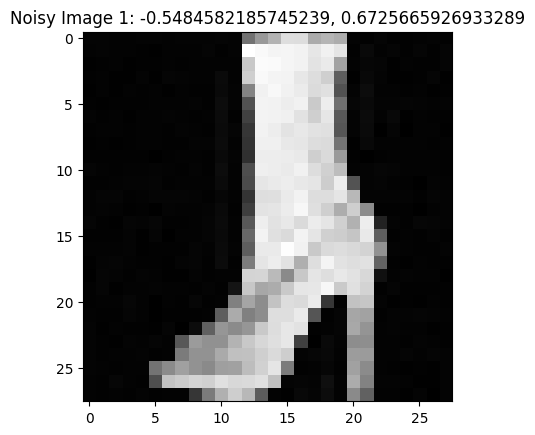

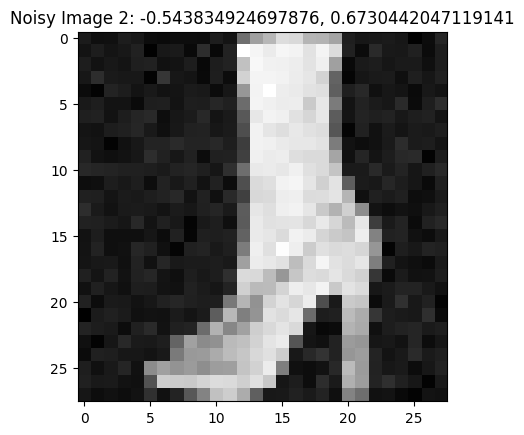

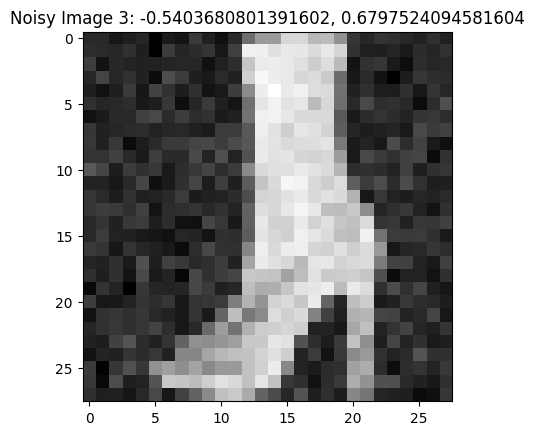

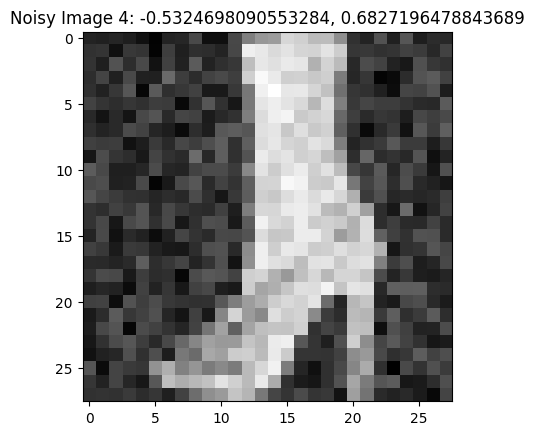

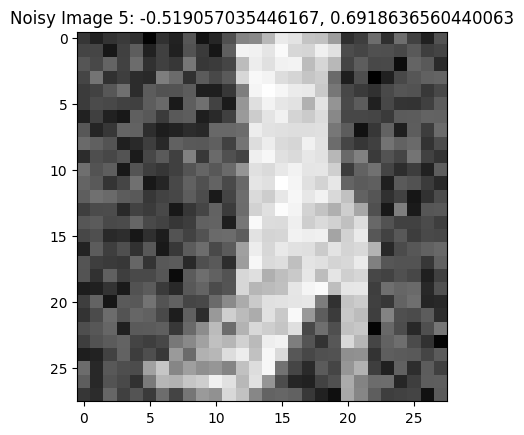

In [11]:
img_tensor = img_tensor.to(device)
mache_noise(img_tensor, 5)

In [12]:
def berechne_alpha_quer_x_forward_steps(anzahl_steps):
    scheduler = create_linear_schedule(anzahl_steps, 0.0001, 0.02)
    alphas = 1 - np.array(scheduler)
    alphas_quer = []
    for i in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:i + 1]))
    return alphas_quer

In [13]:
def x_forward_steps(curr_image, alpha_quer):
    alpha_quer = torch.tensor(alpha_quer, dtype=torch.float32).to(device)  # 'device' is your CUDA device
    std = torch.sqrt(1 - alpha_quer)
    mean = torch.sqrt(alpha_quer) * curr_image
    new_image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return new_image, eps

In [14]:
def mache_noise_direkt(image, anzahl_steps, total_steps=1000):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    noisy_image_tensor = image
    
    alpha_quer = berechne_alpha_quer_x_forward_steps(total_steps)
    
    noisy_image_tensor, eps = x_forward_steps(noisy_image_tensor, alpha_quer[anzahl_steps-1])
    noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
    
    return noisy_image_tensor, eps


In [15]:
def mache_noise_direkt_random(batch_images, total_steps=1000, device=device):
    # Verschieben Sie den Batch auf die GPU
    batch_images = batch_images.to(device)
    
    # Annahme: batch_images hat die Form [batch_size, channels, height, width]
    batch_size = batch_images.size(0)
    
    alpha_quer_list = berechne_alpha_quer_x_forward_steps(total_steps)
    alpha_quer = torch.tensor(alpha_quer_list, device=device)

    noisy_batch = []
    epsilons = []
    anzahl_steps_array = np.empty(batch_size)
    # for loop vernichten
    for i in range(batch_size):
        anzahl_steps = np.random.randint(total_steps)
        anzahl_steps_array[i] = anzahl_steps
        
        image = batch_images[i]
        noisy_image, eps = x_forward_steps(image.unsqueeze(0).to(device), alpha_quer[anzahl_steps-1])  # Verschieben auf die GPU
        
        noisy_batch.append(noisy_image)
        epsilons.append(eps)
    
    noisy_batch_tensor = torch.cat(noisy_batch, dim=0).to(device)  # Verschieben auf die GPU
    epsilons_tensor = torch.cat(epsilons, dim=0).to(device)  # Verschieben auf die GPU
    
    return noisy_batch_tensor, epsilons_tensor, anzahl_steps_array


In [16]:
# U-net architecture: Eingabe (Bild) -> Ausgabe (Segmentation map)

In [17]:
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            
        )

    def forward(self, x):
        return self.double_conv(x)


In [18]:
class DownStride(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [19]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            #nn.MaxPool2d(2),
            nn.Conv2d(in_channels, in_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [20]:
# Comments inspired from https://distill.pub/2016/deconv-checkerboard/

#Stride 1 deconvolutions — which we often see as the last layer in successful models 
#(eg. [2])  — are quite effective at dampening artifacts. 
#In particular, deconvolution has uneven overlap when the kernel size 
#(the output window size) is not divisible by the stride (the spacing between points on the top).

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        #Another approach is to separate out upsampling to a higher resolution from convolution to compute features.
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        #Diese Zeilen berechnen die Größenunterschiede
        #in den Höhen- und Breitenrichtungen zwischen x2 und dem upgesampleten x1.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        #Diese Zeile fügt x1 an den Rändern Polster hinzu, 
        #sodass es die gleiche räumliche Größe wie x2 hat. Das 
        #Padding sorgt dafür, dass die beiden Feature-Maps aneinander angehängt werden können.

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [21]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [22]:
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table)#.unsqueeze(0)

In [23]:
def concat_pos_param(x, enc):
    if x.shape[0] == 1:
        pos_enc_reshape = enc[None,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        feature_map_with_encoding = torch.cat([x.to(device), pos_enc_reshape.to(device)], dim=1)
    else: 
        pos_enc_reshape = enc[:,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        feature_map_with_encoding = torch.cat([x.to(device), pos_enc_reshape.to(device)], dim=1)
    return feature_map_with_encoding

In [24]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, t_max=1000, d_hid=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        factor = 2
        self.pos_enc = nn.parameter.Parameter(get_sinusoid_encoding_table(t_max, d_hid), requires_grad=False)
        #self.pos_enc.requires_grad = False 
        self.inc = (DoubleConv(n_channels + d_hid, 256))
        self.down1 = (Down(256 + d_hid, 512))
        self.down2 = (Down(512 + d_hid, 1024 // factor))
        #self.down3 = (Down(256, 512))
        #self.down4 = (Down(512, 1024 // factor))
        #self.up1 = (Up(1024, 512 // factor))
        #self.up2 = (Up(512, 256 // factor))
        self.up3 = (Up(1024, 512 // factor))
        self.up4 = (Up(512, 256))
        self.outc = (OutConv(256, n_channels))

    def forward(self, x, t):
        enc = self.pos_enc[t]
        #enc_reshape = enc[:,:,None,None].expand((-1,-1,x.shape[-2],x.shape[-1]))
        #enc = self.pos_enc[t]
        #print(torch.cat([x, enc_reshape],dim=1).shape)
        x1 = self.inc(concat_pos_param(x,enc))
        x2 = self.down1(concat_pos_param(x1, enc))
        x3 = self.down2(concat_pos_param(x2, enc))
        #x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        #x = self.up2(x, x3)
        x = self.up3(x3, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

In [25]:
unet = UNet(1,100)
unet = unet.to(device)
dataiter = iter(trainloader)
i, data = next(dataiter)
i = i.to(device)

In [26]:
unet.to(device)
B, H, W = 5, 28, 28
ts = torch.randint(0,1001, size=(B,)).long().to(device)
xs = torch.randn(size=(B,1,H,W)).to(device)
unet(xs, ts)

tensor([[[[ 1.7853e-01,  4.5808e-02, -1.3290e-01,  ...,  4.8533e-02,
            7.7407e-02, -1.3435e-01],
          [ 2.1875e-04,  6.2651e-01,  1.8846e-01,  ...,  2.6964e-01,
            2.7485e-01,  9.9842e-02],
          [ 1.1294e-01,  5.1439e-01,  2.1228e-01,  ...,  3.0640e-01,
            4.5793e-01, -2.8181e-01],
          ...,
          [-3.4608e-01, -1.2980e-01,  2.2054e-01,  ...,  6.3443e-03,
            5.7654e-01,  2.2715e-01],
          [-2.1766e-01,  3.2981e-01,  1.6386e-01,  ...,  3.8129e-02,
            2.0810e-01,  3.1898e-01],
          [ 2.3445e-01,  7.9416e-01,  1.4037e-01,  ...,  6.3426e-01,
            3.3502e-01,  2.9880e-01]]],


        [[[-3.9071e-02,  2.9217e-01,  3.5211e-01,  ...,  5.3401e-01,
            1.6273e-01,  1.2000e-01],
          [ 4.6397e-02,  3.3338e-01,  2.2765e-02,  ...,  1.2032e-01,
           -1.1482e-01, -3.6689e-01],
          [ 2.9508e-01,  7.5642e-01,  3.7915e-01,  ...,  1.3559e+00,
            4.9035e-01,  3.8897e-01],
          ...,
   

torch.Size([5, 32])


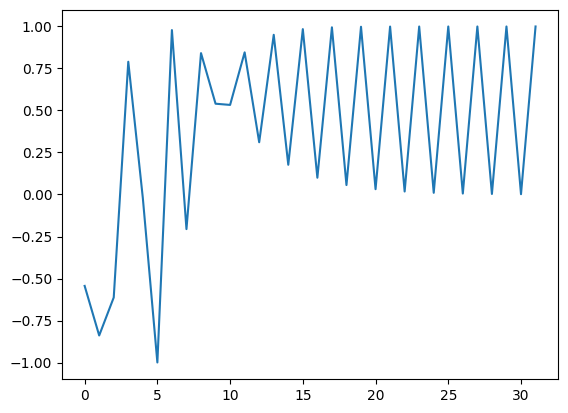

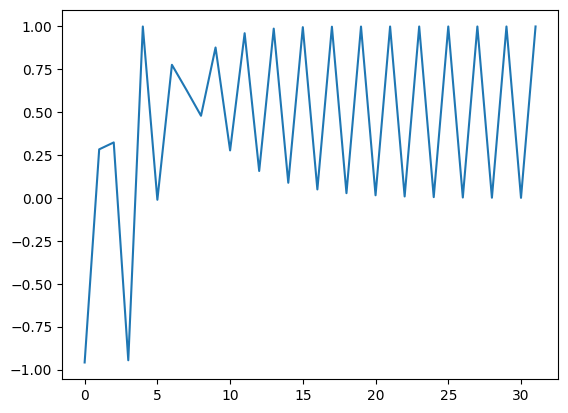

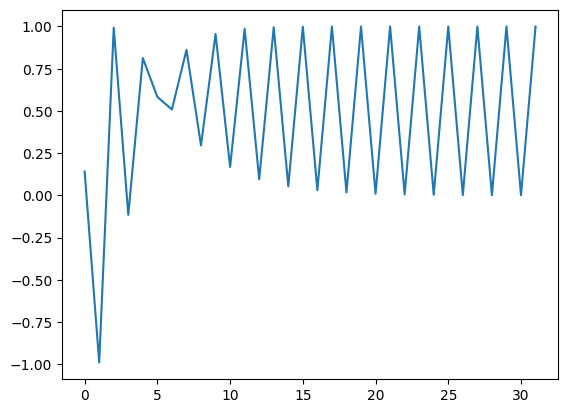

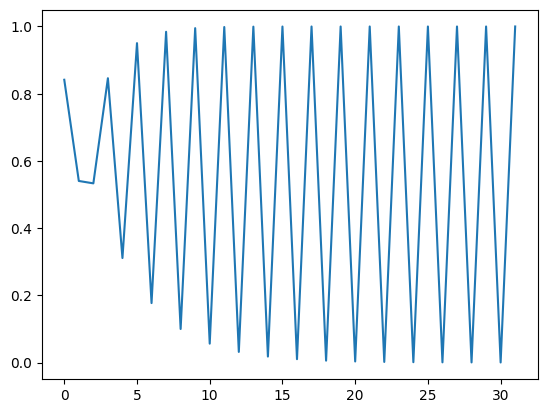

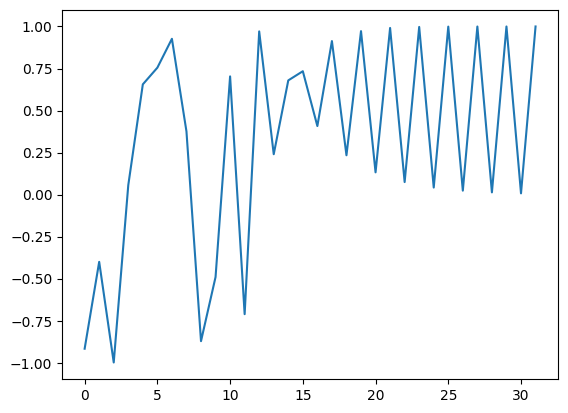

In [27]:
pos_enc_func = unet.pos_enc
print(pos_enc_func[torch.tensor([10,5,3,1,42]).long()].shape)
for fingerprint in pos_enc_func[torch.tensor([10,5,3,1,42]).long()]:
    plt.plot(fingerprint.cpu())
    plt.show()

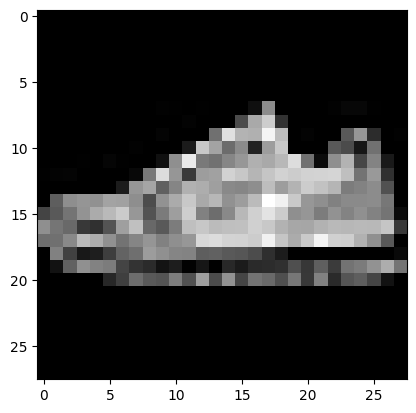

In [28]:
plt.imshow(i[0, 0, :, :].cpu(), cmap='gray')
plt.show()


In [29]:
learning_rate = 0.002
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate, weight_decay = 0.001)

def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    

    
    progress_bar = tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False)
    for batch in progress_bar:
        image, mask_true = batch[0], batch[1]

            # move images and labels to correct device and type
        image = image.to(dtype=torch.float32, memory_format=torch.channels_last).cpu()
        noisy_image, eps, anzahl_schritte = mache_noise_direkt_random(image)
        mask_true = mask_true.to(dtype=torch.long)
        
        mask_pred = net(noisy_image, anzahl_schritte).to(device)
        
        loss = criterion(mask_pred, eps)
        
        


    net.train()
    return 

In [30]:
def train_model(
        model,
        device,
        epochs: int = 2500,
        learning_rate: float = 1e-4,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 1.0,
):
    
    min_loss = 1e25
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        mean_epoch_loss = []
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            image, mask_true = [t.to(device) for t in data]
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            image = image.to(dtype=torch.float32, memory_format=torch.channels_last)
            noisy_image, eps, anzahl_schritte = mache_noise_direkt_random(image)
            mask_true = mask_true.to(dtype=torch.long)

            mask_pred = model(noisy_image, anzahl_schritte).to(device)

            loss = criterion(mask_pred, eps)
            mean_epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        loss_mean = np.mean(mean_epoch_loss)
        if loss_mean < min_loss:
            min_loss = loss_mean
            torch.save(model, 'best_fmnist_model.pt')
        if epoch%100==0:
            print('---')
            print(f"Epoch: {epoch} | Train Loss {loss_mean}")

                
    evaluate(model, valloader, device) 


In [ ]:
train_model(unet, device)

  0%|                                                                                                                                                                                                                                                                                   | 0/2500 [00:00<?, ?it/s, T of [59]=1]/tmp/ipykernel_25764/1524519049.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_quer = torch.tensor(alpha_quer, dtype=torch.float32).to(device)  # 'device' is your CUDA device
  0%|                                                                                                                                                                                                                                                                       | 1/2500 [00:55<38:23:31, 55.31s/it, T of [59]=59]

---
Epoch: 0 | Train Loss 0.5979605286808337


  0%|                                                                                                                                                                                                                                                                       | 1/2500 [01:20<38:23:31, 55.31s/it, T of [59]=26]

In [ ]:
def try_to_revert(noise, eps, anzahl_schritte, total_schritte=1000):
    alpha_quers = berechne_alpha_quer_x_forward_steps(total_schritte)
    return (noise - eps * np.sqrt(1-alpha_quers[anzahl_schritte - 1]))/np.sqrt(alpha_quers[anzahl_schritte - 1])
    

In [ ]:
dataiter = iter(trainloader)
i, data = next(dataiter)
t_zahl = 50

plt.imshow(i[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Original Bild")
plt.show()

img_noise, eps = mache_noise_direkt(i[0:1].to(device), t_zahl)

plt.imshow(img_noise[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Verrauschtes Bild (Eingabe in das Netz)")
plt.show()
print(img_noise.shape)
img_pred = unet(img_noise, t_zahl)



plt.imshow(img_pred[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Geschätztes Epsilon (Ausgabe vom Netz)")
plt.show()



plt.imshow(eps[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Richtiges Epsilon")
plt.show()

reverted_img = try_to_revert(img_noise, img_pred, t_zahl)

plt.imshow(reverted_img[0,0].cpu().detach().numpy(), cmap="gray")
plt.title("Umkehrung des Rauschens mit Prediction")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # 1 Reihe, 5 Spalten

# Original Bild
axs[0].imshow(i[0, 0].cpu().detach().numpy(), cmap="gray")
axs[0].set_title("Original Bild")
axs[0].axis('off')

# Verrauschtes Bild
img_noise, eps = mache_noise_direkt(i[0:1].to(device), t_zahl)
axs[1].imshow(img_noise[0, 0].cpu().detach().numpy(), cmap="gray")
axs[1].set_title("Verrauschtes Bild")
axs[1].axis('off')

# Geschätztes Epsilon
img_pred = unet(img_noise, t_zahl)
axs[2].imshow(img_pred[0, 0].cpu().detach().numpy(), cmap="gray")
axs[2].set_title("Geschätztes Epsilon")
axs[2].axis('off')

# Richtiges Epsilon
axs[3].imshow(eps[0, 0].cpu().detach().numpy(), cmap="gray")
axs[3].set_title("Richtiges Epsilon")
axs[3].axis('off')

# Umkehrung des Rauschens
reverted_img = try_to_revert(img_noise, img_pred, t_zahl)
axs[4].imshow(reverted_img[0, 0].cpu().detach().numpy(), cmap="gray")
axs[4].set_title("Umkehrung des Rauschens")
axs[4].axis('off')

plt.show()


In [ ]:
plt.imshow(img_noise[0,0].cpu().detach().numpy(), cmap="gray")
plt.show()

plt.imshow(reverted_img[0,0].cpu().detach().numpy(), cmap="gray")
plt.show()

In [ ]:
betas = create_linear_schedule(1000, 0.0001, 0.02)
alphas = 1 - np.array(betas)
alphas_quer = []
for k in range(len(alphas)):
    alphas_quer.append(np.prod(alphas[:k + 1]))

img_noise, eps = mache_noise_direkt(i[0:1].to(device), 1000)
img_noise = torch.randn_like(img_noise)
for j in reversed(range(999)):    
    img_pred = unet(img_noise, j)
    if j > 1:
        z = torch.randn_like(img_noise)
    else:
        z = torch.zeros_like(img_noise)
        
    img_noise = (1/np.sqrt(alphas[j+1])) * (img_noise - (1- alphas[j+1])/(np.sqrt(1-alphas_quer[j+1])) * img_pred) + np.sqrt((1-alphas_quer[j])/(1-alphas_quer[j+1]) *betas[j+1])*z

    if j%100 == 0:
        plt.imshow(img_noise[0,0].cpu().detach().numpy(), cmap="gray")
        plt.show()
    # kann noch in die letzte Wurzel eingefügt werden (alternative Definition aus DDPM für Sigma^2)
print(img_noise.shape)


In [ ]:
plt.imshow(img_noise[0,0].cpu().detach().numpy(), cmap="gray")
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4)) 

test_i, eps, zahlen = mache_noise_direkt_random(i)# 1 Reihe, 5 Spalten

axs[0].imshow(test_i[0, 0].cpu().detach().numpy(), cmap="gray")
axs[0].axis('off')

axs[1].imshow(test_i[400, 0].cpu().detach().numpy(), cmap="gray")
axs[1].axis('off')

axs[2].imshow(test_i[800, 0].cpu().detach().numpy(), cmap="gray")
axs[2].axis('off')

axs[3].imshow(test_i[1200, 0].cpu().detach().numpy(), cmap="gray")
axs[3].axis('off')

axs[4].imshow(test_i[1600, 0].cpu().detach().numpy(), cmap="gray")
axs[4].axis('off')

plt.show()
